In [6]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *
data_dict = load_data(verbose=True)

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori, tango_ori, tango_pos
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce, game_rv, grav, gyro, gyro_uncalib, linacce, magnet, rv, time


In [19]:
w = data_dict['synced/gyro']
N = 20000
# 100 time steps
q_gt = data_dict['pose/tango_ori'][:N]
dt = data_dict['synced/time'][1] - data_dict['synced/time'][0]
q_pred_ana = np.zeros((N,4))
q_pred_ana[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,N):
    q_pred_ana[i] = Theta(w[i]*factor, dt=dt)@q_pred_ana[i-1]



q_pred (20000, 4) q_gt (20000, 4) x (20000,)


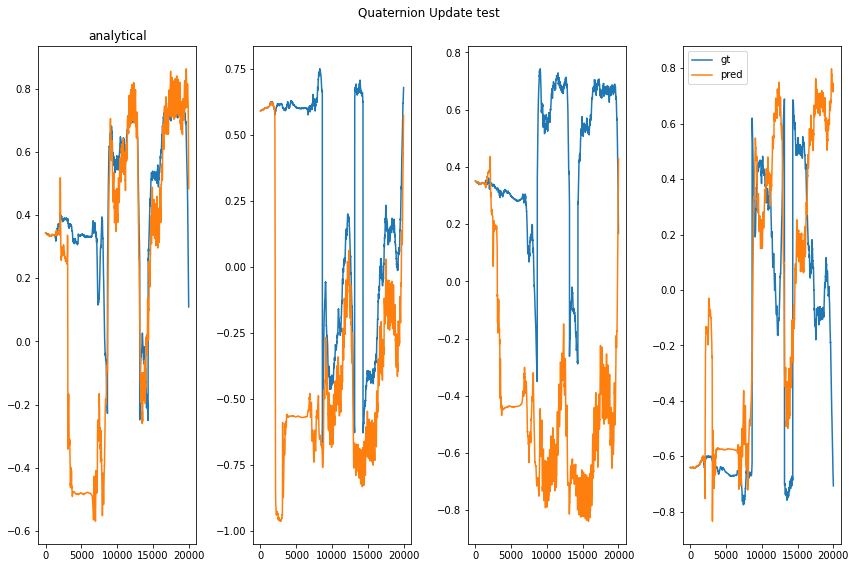

In [37]:
# plot
def plot_quat(q_gts, q_preds, xs, names = ['analytical', 'NN']):
    if type(q_preds) is not list:
        q_preds = [q_preds]
    if type(q_gts) is not list:
        q_gts = [q_gts]
    if type(xs) is not list:
        xs = [xs]
    
    fig, ax = plt.subplots(len(q_preds), 4, figsize=(12, 8))
    ax = ax.reshape(-1, 4)
    idx = 0
    for q_pred, q_gt,x, name in zip(q_preds, q_gts,xs, names):
        print('q_pred', q_pred.shape, 'q_gt', q_gt.shape, 'x', x.shape)
        ax[idx, 0].plot(x, q_gt[:,0],)
        ax[idx, 0].plot(x, q_pred[:,0],)
        ax[idx, 1].plot(x, q_gt[:,1],)
        ax[idx, 1].plot(x, q_pred[:,1],)
        ax[idx, 2].plot(x, q_gt[:,2],)
        ax[idx, 2].plot(x, q_pred[:,2],)
        ax[idx, 3].plot(x, q_gt[:,3],label='gt')
        ax[idx, 3].plot(x, q_pred[:,3],label=f'pred')
        
        ax[idx, 0].set_title(name)
        idx += 1
    ax[0, 3].legend()
    fig.suptitle('Quaternion Update test')
    plt.tight_layout()

plot_quat(q_gt, q_pred_ana, np.arange(len(q_gt)))

## NN

In [9]:
# set up a neural network with 3 inputs and 16 outputs
# the 3 inputs are the 3 components of the angular velocity
# the 16 outputs are the 16 elements of the 4x4 matrix Theta(w)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size=13, output_size=16, hidden_size=16, num_layers=2):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.fc_input = nn.Linear(input_size, hidden_size)
        hidden_layers = []
        for i in range(self.num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x)
        x = F.relu(self.fc_input(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layers[i](x))
            
        x = self.fc_output(x)
        return x
    
net = Net(input_size=124, output_size=4, hidden_size=64, num_layers=10)

# number of params
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 49860


In [10]:
def get_data(start=0, stop=1500, group_num=40):

    ori =data_dict['pose/tango_ori'][start:stop]  
    w = data_dict['synced/gyro'][start:stop]
    a = data_dict['synced/acce'][start:stop]
    m = data_dict['synced/magnet'][start:stop]
    #print shapes
    print('ori.shape', ori.shape, 'w.shape', w.shape, 'a.shape', a.shape, 'm.shape', m.shape)
    # every 10
    w = w[:-(w.shape[0]%group_num)] if w.shape[0]%group_num != 0 else w
    ori = ori[:-(ori.shape[0]%group_num)] if ori.shape[0]%group_num != 0 else ori

    # reshape
    w_10 = w.reshape(-1,group_num*w.shape[1])
    ori_10 = ori.reshape(-1,group_num*ori.shape[1])
    
    print('w_10.shape', w_10.shape)
    print('ori_10.shape', ori_10.shape)

    X = np.hstack([w_10, ori_10[:,:4] ])
    y = ori_10[:,-4:]  

    print(X.shape, y.shape)

    return X, y

X, y = get_data(start=0, stop=20000)


ori.shape (20000, 4) w.shape (20000, 3) a.shape (20000, 3) m.shape (20000, 3)
w_10.shape (500, 120)
ori_10.shape (500, 160)
(500, 124) (500, 4)


In [11]:
# data preparation


# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)

# convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)






In [42]:
# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# loss function
criterion = nn.L1Loss()

# train
num_epochs = 100

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d, loss: %.5f' % (epoch+1, running_loss))

    # test
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        print('Test loss: %.5f' % running_loss)


Epoch 1, loss: 0.49881
Test loss: 0.16936
Epoch 2, loss: 0.54021
Test loss: 0.11859
Epoch 3, loss: 0.32392
Test loss: 0.11650
Epoch 4, loss: 0.34938
Test loss: 0.08085
Epoch 5, loss: 0.28231
Test loss: 0.07436
Epoch 6, loss: 0.26117
Test loss: 0.07987
Epoch 7, loss: 0.22750
Test loss: 0.06559
Epoch 8, loss: 0.21014
Test loss: 0.05625
Epoch 9, loss: 0.22354
Test loss: 0.04423
Epoch 10, loss: 0.21370
Test loss: 0.05119
Epoch 11, loss: 0.22563
Test loss: 0.04998
Epoch 12, loss: 0.16027
Test loss: 0.05045
Epoch 13, loss: 0.16841
Test loss: 0.04921
Epoch 14, loss: 0.14813
Test loss: 0.03932
Epoch 15, loss: 0.13554
Test loss: 0.04102
Epoch 16, loss: 0.13404
Test loss: 0.05975
Epoch 17, loss: 0.15784
Test loss: 0.04848
Epoch 18, loss: 0.18392
Test loss: 0.04729
Epoch 19, loss: 0.16924
Test loss: 0.04370
Epoch 20, loss: 0.15703
Test loss: 0.07168
Epoch 21, loss: 0.15558
Test loss: 0.04385
Epoch 22, loss: 0.14060
Test loss: 0.05134
Epoch 23, loss: 0.13438
Test loss: 0.04662
Epoch 24, loss: 0.13

ori.shape (20000, 4) w.shape (20000, 3) a.shape (20000, 3) m.shape (20000, 3)
w_10.shape (500, 120)
ori_10.shape (500, 160)
(500, 124) (500, 4)
q_pred (20000, 4) q_gt (20000, 4) x (20000,)
q_pred (500, 4) q_gt (500, 4) x (500,)


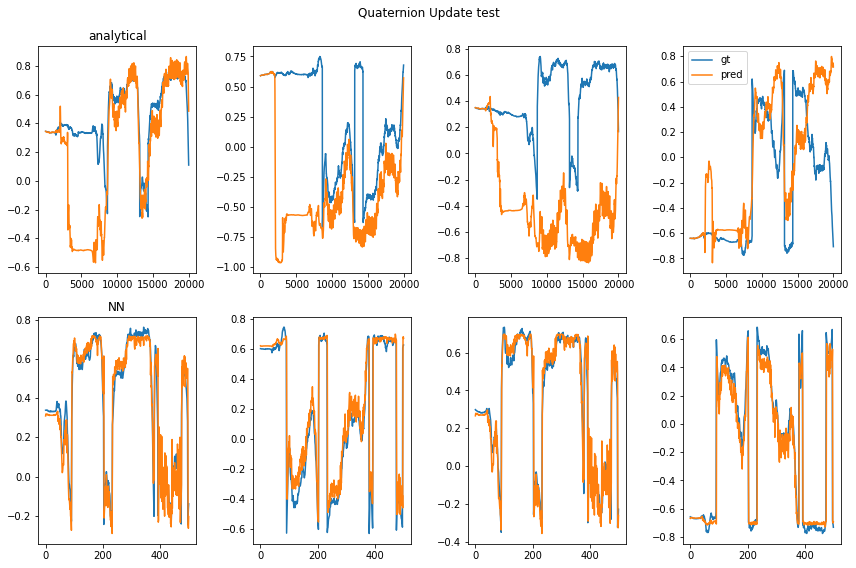

In [44]:
# testing unseen         

n_unseen = 20000
start, end = 5000, 5000+n_unseen
#start, end = 0, n_unseen


X_unseen, y_unseen = get_data(start=start, stop=end)


y_pred = []
with torch.no_grad():
    for i in range(len(X_unseen)):
        if i > 0:
            X_unseen[i, 0:4] = y_pred[i-1]
        inputs = torch.from_numpy(X_unseen[i]).float()
        outputs = net(inputs)
        y_pred.append(outputs.numpy())


y_pred = np.array(y_pred)
q_gts = [q_gt, y_unseen]
q_preds = [q_pred_ana, y_pred]
xs = [np.arange(len(q_gt)), np.arange(len(y_unseen))]
plot_quat(q_gts, q_preds, xs, names = ['analytical', 'NN'])
plt.savefig('../assets/quat_nn.png')


In [14]:
# so i think we might have a problem due to the fact that we have limit precision and  we are sampling very often. So the angular velocity doesnt have time to change the quaternion below the precision limit. As such we could try to only compare every 10 samples or so.